# Set Up

In [1]:
!pip install seaborn
!pip install scipy

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special as sp
from scipy.constants import physical_constants

---

# Physical Equations

In [2]:
def radial_function(n, l, r, b_r):
    """
    Calculates the radial part of the normalized wavefunction for the hydrogen atom.

    Args:
        n (int): Principal quantum number.
        l (int): Azimuthal quantum number.
        r (numpy.ndarray): Radial coordinate.
        b_r (float): Scaled Bohr radius.

    Returns:
        numpy.ndarray: Normalized radial wavefunction.
    """
    
    laguerre_polynomial = sp.genlaguerre(n - l - 1, 2 * l + 1)
    
    radial_variable = 2 * r / (n * b_r)

    # Normalization factor
    normalization_factor = np.sqrt(
        ((2 / n * b_r) ** 3 * (sp.factorial(n - l - 1))) /
        (2 * n * (sp.factorial(n + l)))
    )

    # Radial function
    return normalization_factor * np.exp(-radial_variable / 2) * (radial_variable ** l) * laguerre_polynomial(radial_variable)

In [3]:
def angular_function(m, l, theta, phi):
    """
    Calculates the angular part of the normalized wavefunction for the hydrogen atom.

    Args:
        m (int): Magnetic quantum number.
        l (int): Azimuthal quantum number.
        theta (numpy.ndarray): Polar angle.
        phi (int): Azimuthal angle.

    Returns:
        numpy.ndarray: Angular component of the wavefunction.
    """
    
    # Legendre polynomial associated with m and l
    legendre_polynomial = sp.lpmv(m, l, np.cos(theta))

    # Normalization factor
    normalization_factor = ((-1) ** m) * np.sqrt(
        ((2 * l + 1) * sp.factorial(l - np.abs(m))) /
        (4 * np.pi * sp.factorial(l + np.abs(m)))
    )

    # Angular function with the exponential phase
    return normalization_factor * legendre_polynomial * np.real(np.exp(1.j * m * phi))

In [4]:
def compute_wavefunction(n, l, m, b_r_scale_factor):
    """
    Calculates the normalized wavefunction as the product of its radial and angular components.

    Args:
        n (int): Principal quantum number.
        l (int): Azimuthal quantum number.
        m (int): Magnetic quantum number.
        b_r_scale_factor (float): Bohr radius scaling factor.

    Returns:
        numpy.ndarray: Wavefunction.
    """
    
    # Scale the Bohr radius for effective visualization
    bohr_radius = b_r_scale_factor * physical_constants['Bohr radius'][0] * 1e+12

    # Define the extent and resolution of the grid to represent the electron's spatial distribution
    grid_extent = 480
    grid_resolution = 680
    grid_z = grid_x = np.linspace(-grid_extent, grid_extent, grid_resolution)
    grid_z, grid_x = np.meshgrid(grid_z, grid_x)

    # Use epsilon to avoid division by zero during angle calculations
    epsilon = np.finfo(float).eps

    # Ψnlm(r,θ,φ) = Rnl(r).Ylm(θ,φ)
    wavefunction = radial_function(
        n, l, np.sqrt((grid_x ** 2 + grid_z ** 2)), bohr_radius
    ) * angular_function(
        m, l, np.arctan(grid_x / (grid_z + epsilon)), 0
    )
    
    return wavefunction

In [5]:
def compute_probability_density(wavefunction):
    """
    Calculates the probability density of a given wavefunction.

    Args:
        wavefunction (numpy.ndarray): Wavefunction.

    Returns:
        numpy.ndarray: Probability density of the wavefunction.
    """
    return np.abs(wavefunction) ** 2

---

# Graphs

In [6]:
def plot_wf_probability_density(n, l, m, b_r_scale_factor, dark_theme=False, colormap='mako'):
    """
    Plots the probability density of the hydrogen atom wavefunction 
    for a given quantum state (n, l, m).

    Args:
        n (int): Principal quantum number, determines the energy level and orbit size.
        l (int): Azimuthal quantum number, defines the shape of the orbit.
        m (int): Magnetic quantum number, defines the orientation of the orbit.
        b_r_scale_factor (float): Bohr radius scaling factor.
        dark_theme (bool): If True, uses a dark background for the plot. Default is False.
        colormap (str): Seaborn colormap for the plot. Default is 'mako'.
    """

    # Validation of the quantum numbers
    if not isinstance(n, int) or n < 1:
        raise ValueError('n must be an integer greater than or equal to 1')
    if not isinstance(l, int) or not (0 <= l < n):
        raise ValueError('l must be an integer such that 0 <= l < n')
    if not isinstance(m, int) or not (-l <= m <= l):
        raise ValueError('m must be an integer such that -l <= m <= l')

    # Validate the colormap
    try:
        sns.color_palette(colormap)
    except ValueError:
        raise ValueError(f'{colormap} is not a recognized colormap in Seaborn.')

    # Configure plot aesthetics using matplotlib rcParams
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['xtick.major.width'] = 4
    plt.rcParams['ytick.major.width'] = 4
    plt.rcParams['xtick.major.size'] = 15
    plt.rcParams['ytick.major.size'] = 15
    plt.rcParams['xtick.labelsize'] = 30
    plt.rcParams['ytick.labelsize'] = 30
    plt.rcParams['axes.linewidth'] = 4

    # Create the figure and axes for the plot
    fig, ax = plt.subplots(figsize=(16, 16.5))
    plt.subplots_adjust(top=0.82, right=0.905, left=-0.1)

    # Calculate and visualize the probability density of the wavefunction
    wavefunction = compute_wavefunction(n, l, m, b_r_scale_factor)
    probability_density = compute_probability_density(wavefunction)
    
    # Transpose the matrix to align the representation with Matplotlib's visualization
    im = ax.imshow(np.sqrt(probability_density).T, cmap=sns.color_palette(colormap, as_cmap=True))

    # Add colorbar
    colorbar = plt.colorbar(im, fraction=0.046, pad=0.03)
    colorbar.set_ticks([])

    # Apply dark theme parameters
    if dark_theme:
        theme = 'dark'
        background_color = sorted(
            sns.color_palette(colormap, n_colors=100),
            key=lambda color: 0.2126 * color[0] + 0.7152 * color[1] + 0.0722 * color[2]
        )[0]
        plt.rcParams['text.color'] = '#dfdfdf'
        title_color = '#dfdfdf'
        fig.patch.set_facecolor(background_color)
        colorbar.outline.set_visible(False)
        ax.tick_params(axis='x', colors='#c4c4c4')
        ax.tick_params(axis='y', colors='#c4c4c4')
        for spine in ax.spines.values():
            spine.set_color('#c4c4c4')
    else:  # Apply light theme parameters
        theme = 'light'
        plt.rcParams['text.color'] = '#000000'
        title_color = '#000000'
        ax.tick_params(axis='x', colors='#000000')
        ax.tick_params(axis='y', colors='#000000')

    # Add title and explanatory text to the plot
    ax.set_title('Hydrogen Atom - Electron Density', 
                 pad=20, fontsize=44, loc='left', color=title_color)
    ax.text(30, 615, r'$({0}, {1}, {2})$'.format(n, l, m), color='#dfdfdf', fontsize=42)
    ax.text(770, 150, 'Electron Probability Distribution', rotation='vertical', fontsize=30)
    ax.text(705, 700, 'Highest\nProbability', fontsize=20)
    ax.text(705, -60, 'Lowest\nProbability', fontsize=20)
    ax.text(775, 590, '+', fontsize=34)
    ax.text(769, 82, '−', fontsize=34, rotation='vertical')
    ax.invert_yaxis()

    # Create the "media" folder if it doesn't exist
    if not os.path.exists('media'):
        os.makedirs('media')

    # Save and display the plot in the "media" folder
    plt.savefig(f'media/({n},{l},{m})[{theme}].png')
    plt.show()

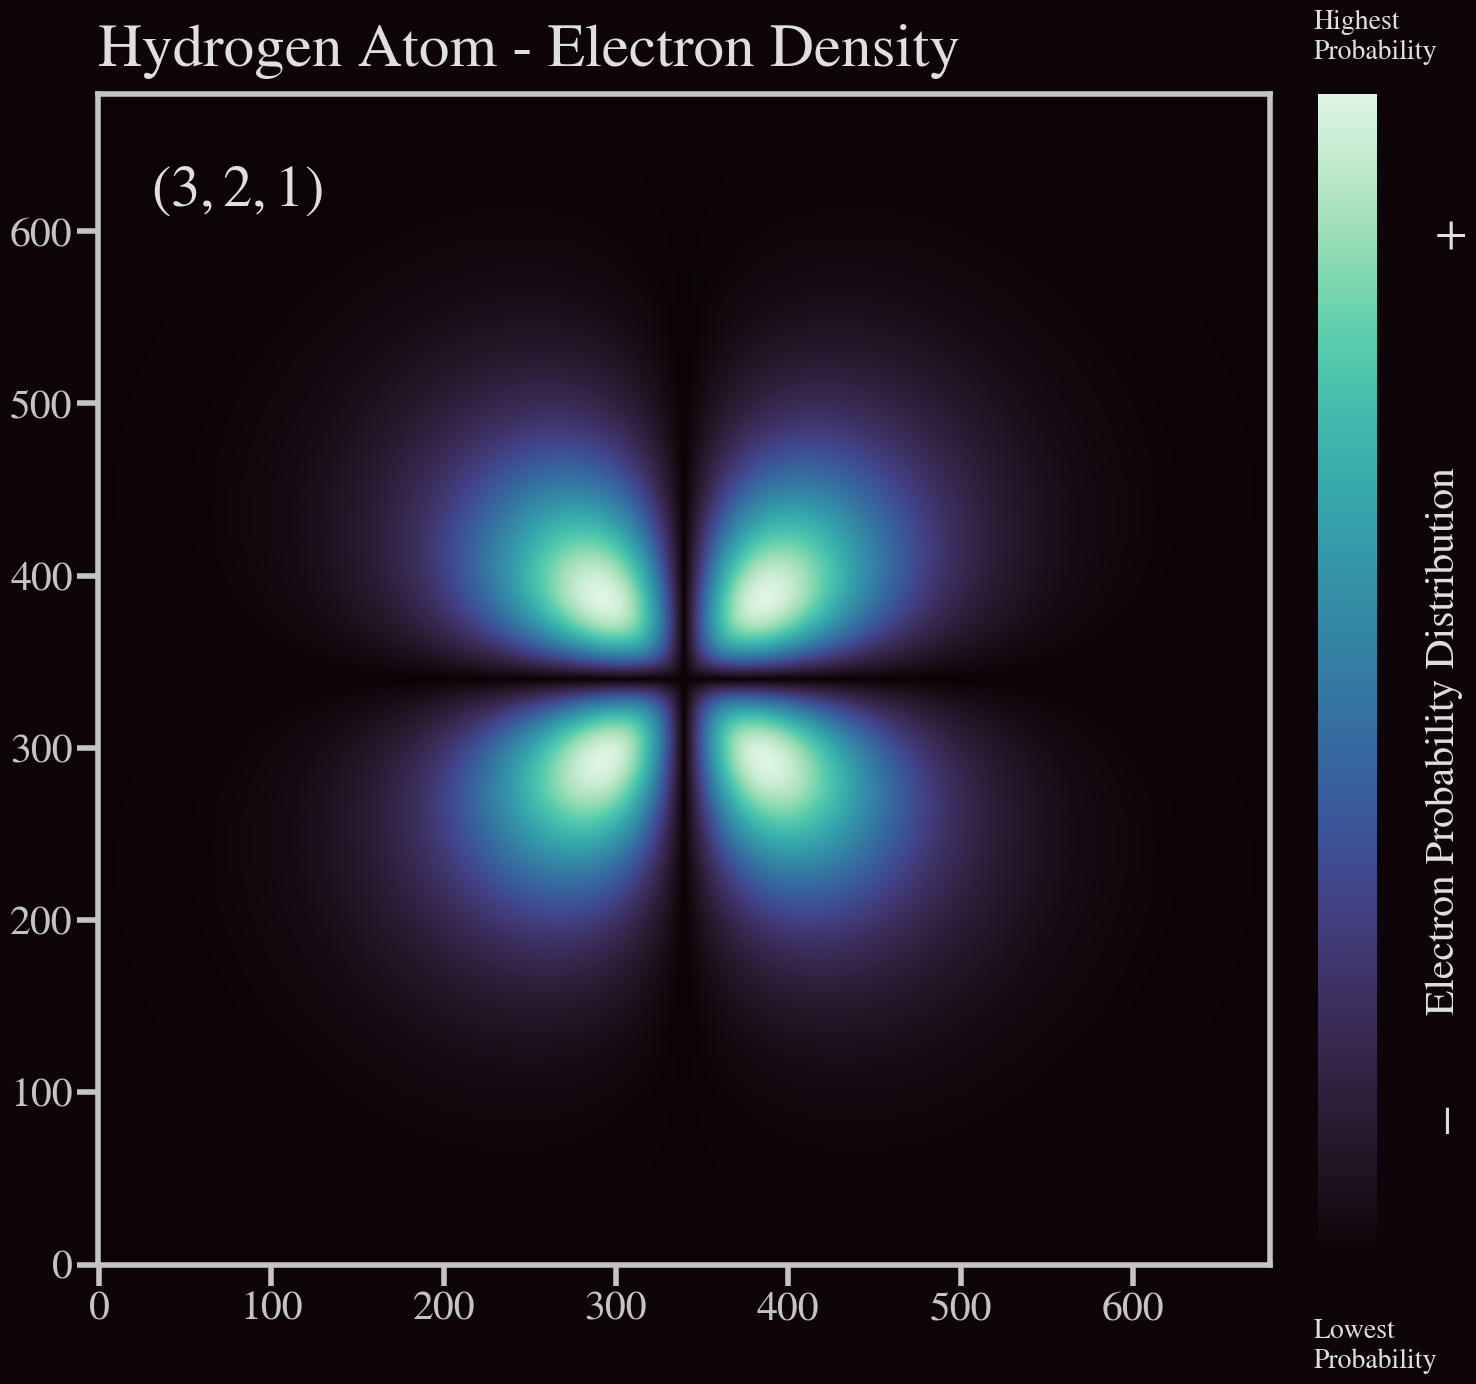

In [7]:
plot_wf_probability_density(3, 2, 1, 0.3, True)

---

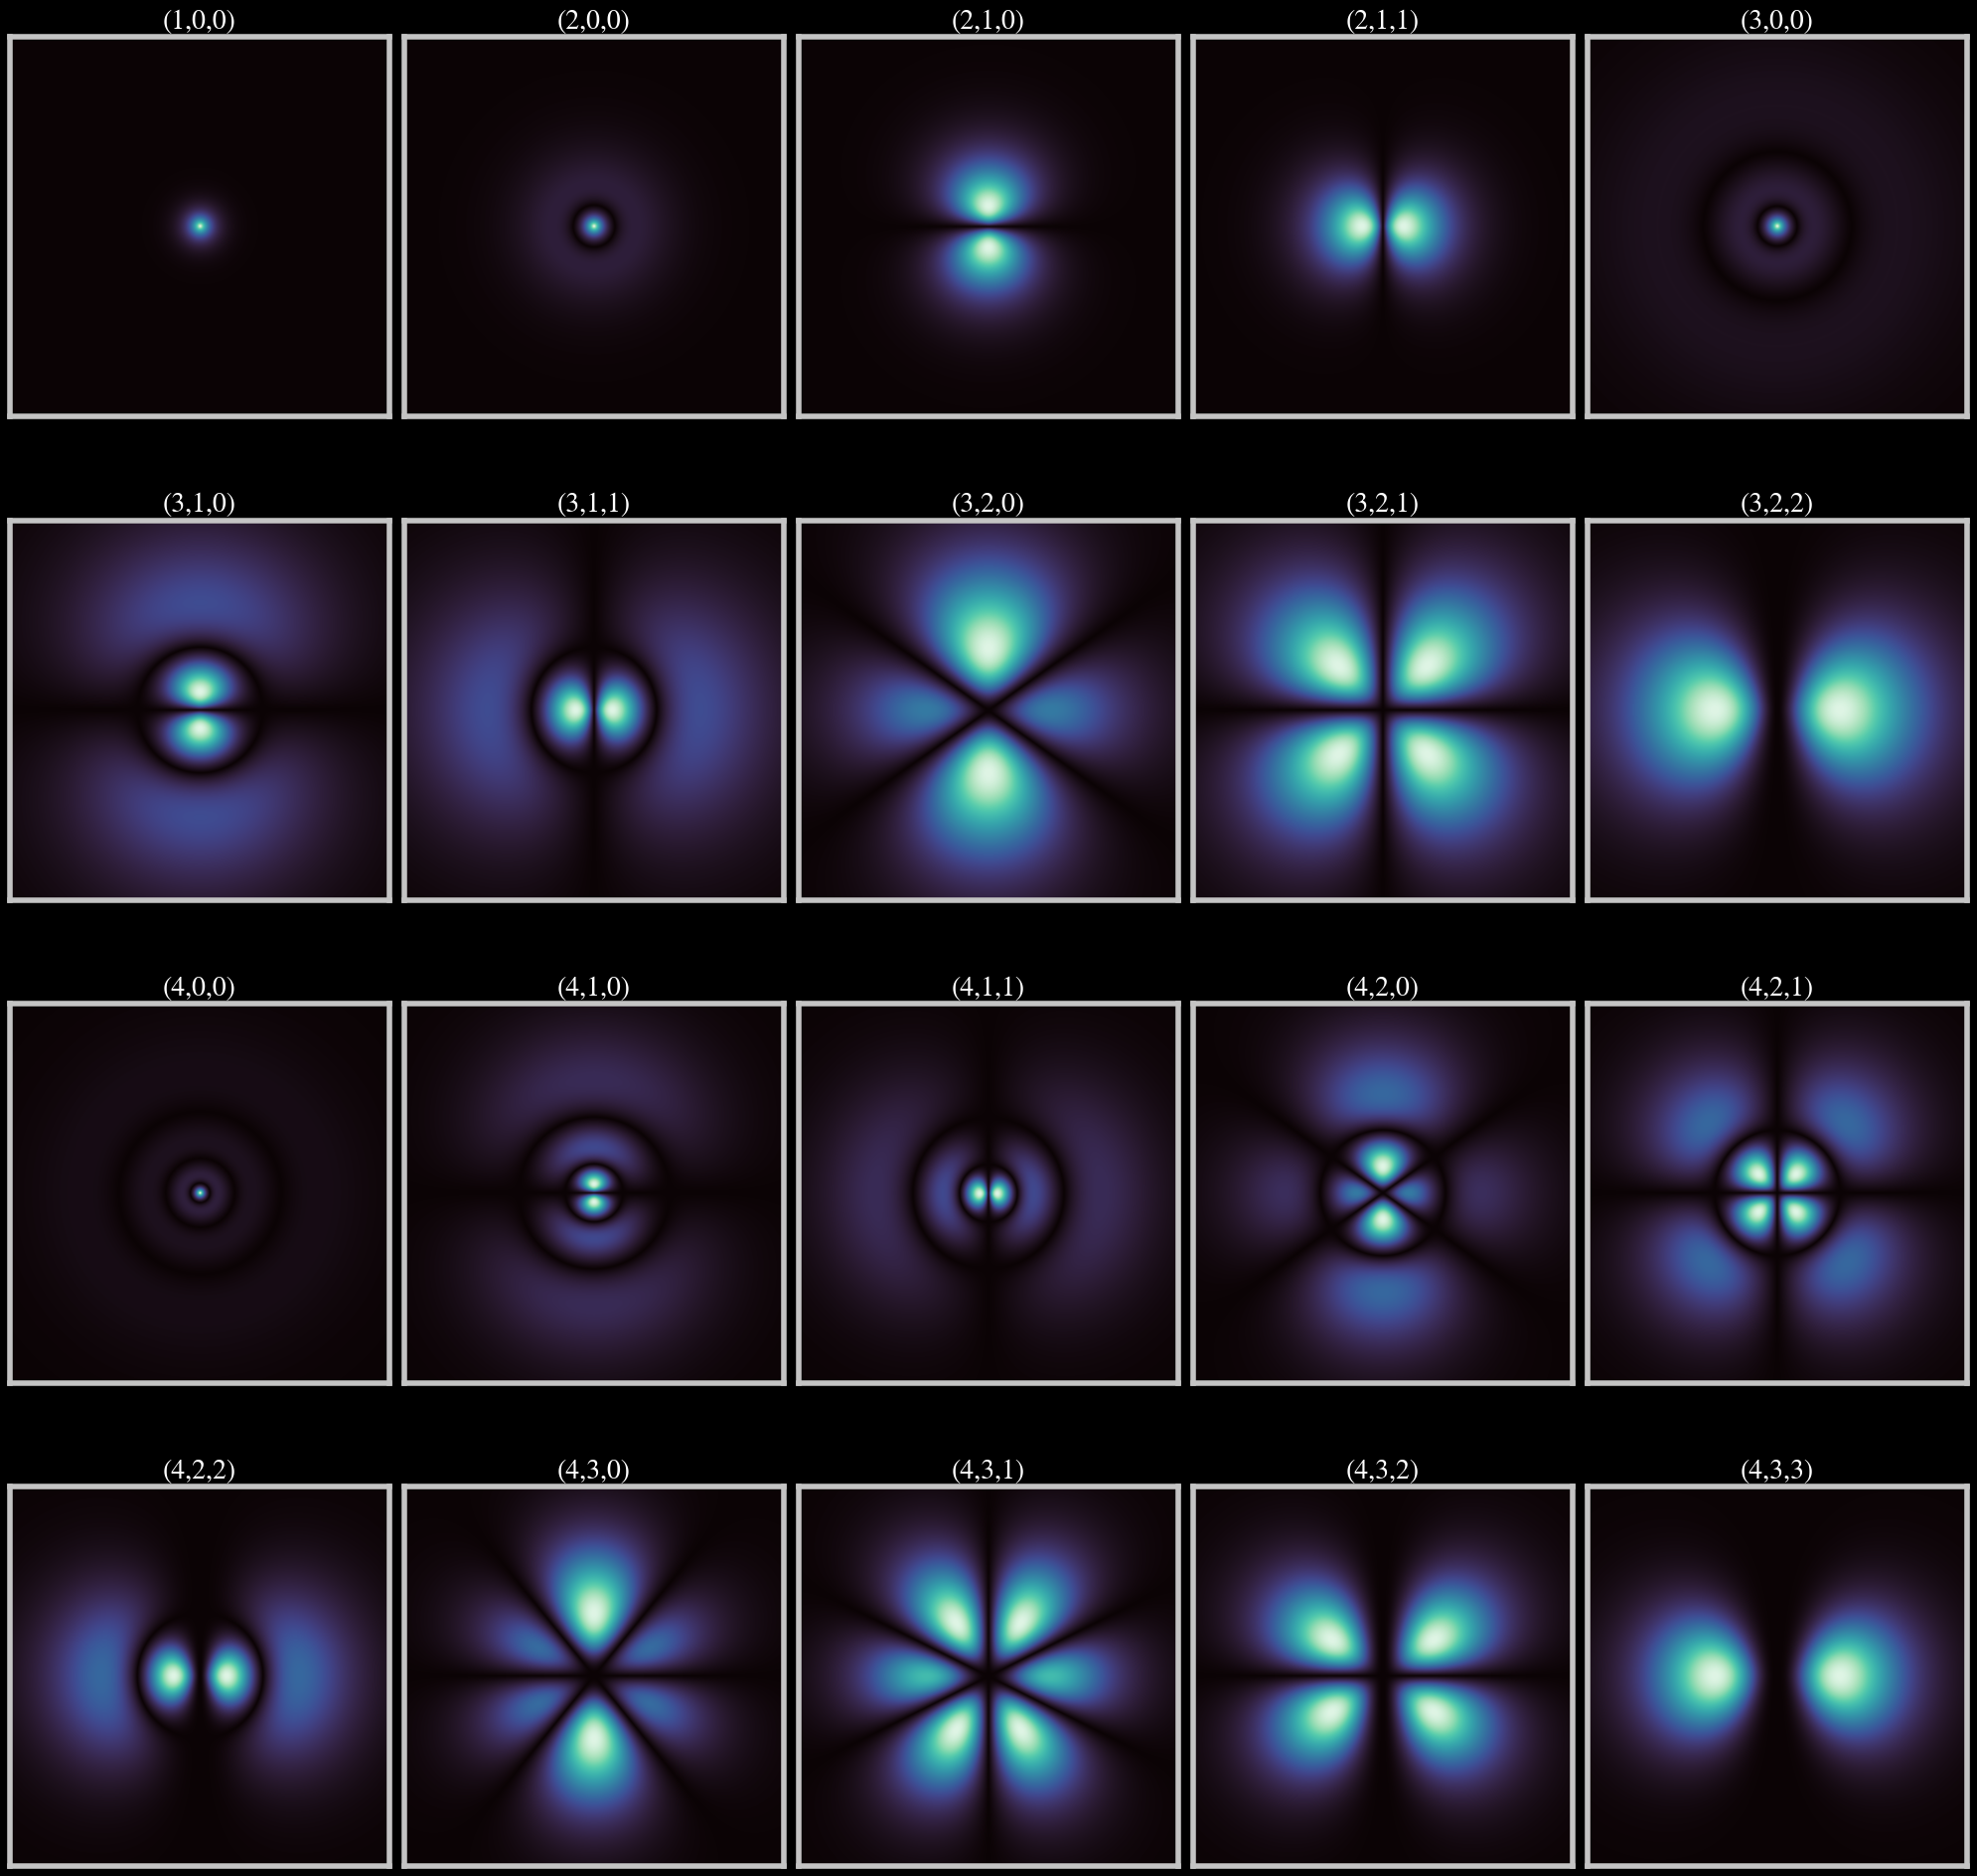

In [8]:
def plot_wf_probability_density(n, l, m, b_r_scale_factor, dark_theme=False, colormap='mako', ax=None):
    """
    Plots the probability density of the hydrogen atom wavefunction 
    for a given quantum state (n, l, m) on a specific axis (ax).

    Args:
        n (int): Principal quantum number, determines the energy level and orbit size.
        l (int): Azimuthal quantum number, defines the shape of the orbit.
        m (int): Magnetic quantum number, defines the orientation of the orbit.
        b_r_scale_factor (float): Bohr radius scaling factor.
        dark_theme (bool): If True, uses a dark background for the plot. Default is False.
        colormap (str): Seaborn colormap for the plot. Default is 'mako'.
        ax (matplotlib.axes.Axes): The axis where the plot will be drawn.
    """
    
    # Validation of the quantum numbers
    if not isinstance(n, int) or n < 1:
        raise ValueError('n must be an integer greater than or equal to 1')
    if not isinstance(l, int) or not (0 <= l < n):
        raise ValueError('l must be an integer such that 0 <= l < n')
    if not isinstance(m, int) or not (-l <= m <= l):
        raise ValueError('m must be an integer such that -l <= m <= l')

    # Validate the colormap
    try:
        sns.color_palette(colormap)
    except ValueError:
        raise ValueError(f'{colormap} is not a recognized colormap in Seaborn.')

    # Configure plot aesthetics using matplotlib rcParams
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['xtick.major.width'] = 4
    plt.rcParams['ytick.major.width'] = 4
    plt.rcParams['xtick.major.size'] = 15
    plt.rcParams['ytick.major.size'] = 15
    plt.rcParams['xtick.labelsize'] = 30
    plt.rcParams['ytick.labelsize'] = 30
    plt.rcParams['axes.linewidth'] = 4

    # Calculate and visualize the probability density of the wavefunction
    wavefunction = compute_wavefunction(n, l, m, b_r_scale_factor)
    probability_density = compute_probability_density(wavefunction)
    
    # Transpose the matrix to align the representation with Matplotlib's visualization
    im = ax.imshow(np.sqrt(probability_density).T, cmap=sns.color_palette(colormap, as_cmap=True))

    # Apply dark theme parameters
    if dark_theme:
        background_color = sorted(
            sns.color_palette(colormap, n_colors=100),
            key=lambda color: 0.2126 * color[0] + 0.7152 * color[1] + 0.0722 * color[2]
        )[0]
        ax.tick_params(axis='x', colors='#c4c4c4')
        ax.tick_params(axis='y', colors='#c4c4c4')
        for spine in ax.spines.values():
            spine.set_color('#c4c4c4')
    else:
        ax.tick_params(axis='x', colors='#000000')
        ax.tick_params(axis='y', colors='#000000')

    # Title for each subplot (quantum numbers)
    ax.set_title(f'({n},{l},{m})', fontsize=20, color='white')

    # Remove axis labels
    ax.set_xticks([])
    ax.set_yticks([])

def plot_all_hydrogen_states(b_r_scale_factor, dark_theme=False, colormap='mako'):
    """
    Generates the probability density plots of the wavefunction for 
    all possible quantum states of the hydrogen atom, displaying a 4x5 grid.
    
    Args:
        b_r_scale_factor (float): Bohr radius scaling factor.
        dark_theme (bool): If True, uses a dark background for the plot. Default is False.
        colormap (str): Seaborn colormap for the plot. Default is 'mako'.
    """
    
    # Create a figure with subplots in a 4x5 grid
    fig, axs = plt.subplots(4, 5, figsize=(20, 20), facecolor='black')
    
    # Define the range for quantum numbers
    max_n = 4
    ax_idx = 0  # Index to traverse the subplots
    for n in range(1, max_n + 1):
        if n == 4:
            b_r_scale_factor /= 2  # Reduce scaling factor when n = 4
        
        for l in range(n):
            for m in range(0, l + 1):
                row, col = divmod(ax_idx, 5)  # Calculate row and column for the plot
                ax = axs[row, col]
                plot_wf_probability_density(n, l, m, b_r_scale_factor, dark_theme, colormap, ax)
                ax_idx += 1  # Move to the next plot
    

    # Create the "media" folder if it doesn't exist
    if not os.path.exists('media'):
        os.makedirs('media')

    # Adjust layout to avoid overlaps
    plt.tight_layout()
    
    # Save and display the plot in the "media" folder
    plt.savefig(f'media/all_states.png')
    plt.show()

# Call the function to plot all states in a 4x5 grid
plot_all_hydrogen_states(b_r_scale_factor=0.5, dark_theme=True, colormap='mako')